# Using Decision Tree & Naive Bayes to classify Legendary Pokemon

## Import libraries

In [1]:
import gc
import random
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import pandas_profiling as pdp
# from sklearn.feature_extraction import FeatureHasher
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
import utils as ut
import decisionTree as dt
import naiveBayes as nb

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
%reload_ext autoreload

In [82]:
# Set packages options
# np.set_printoptions(threshold=np.nan)
# pd.set_option("display.max_columns", 600)
plt.rcParams["figure.figsize"] = (11, 6)

## Define constants and functions

In [115]:
# Constants
TypeColorMappings = {"Water": "#6890F0", "Fire": "#F08030", "Grass": "#78C850",
                     "Dark": "#705848", "Electric": "#F8D030", "Flying": "#A890F0",
                     "Normal": "#A8A878", "Fighting": "#C03028", "Poison": "#A040A0",
                     "Ground": "#E0C068", "Psychic": "#F85888", "Rock": "#B8A038", 
                     "Ice": "#98D8D8", "Bug": "#A8B820", "Dragon": "#7038F8", 
                     "Ghost": "#705898", "Steel": "#B8B8D0", "Fairy": "#EE99AC"}

# DropColumns = ["Pokedex#", "Name", "Type 1", "Type 2", "Generation", "Ability 1", "Ability 2", "Ability 3", 
#                "EggGroup 1", "EggGroup 2", "Category", "Height (m)", "Weight (kg)"]

DropColumns = ["Pokedex#", "Name", "Generation", "Category"]

def getColorList(typeCounts):
    assert type(typeCounts) == pd.core.series.Series, "Argument must be a Series object"
    return [TypeColorMappings[pokemonType] for pokemonType in typeCounts.index]

def getDistinctValues(dataFrame, columnName, sep):
    result = []
    for value in dataFrame[columnName].value_counts().index:
        result += value.split(sep)
    return set(result)

def getRandomColor():
    return "#%02X%02X%02X" % (random.randint(0,255), random.randint(0,255), random.randint(0,255))

## Load the data from file

In [3]:
# Load the Pokemon data
fileName = r'.\Pokemon_Cleaned.tsv'
columnTypes = {"Name": str, "Category": str, "Type 1": str, "Type 2": str, 
               "Ability 1": str, "Ability 2": str, "Ability 3": str, "Group": str}
data = pd.read_csv(fileName, header=0, sep='\t', dtype=columnTypes)
data.head()

,Generation,Pokedex#,Name,Category,Type 1,Type 2,Ability 1,Ability 2,Ability 3,MaleRatio,...,EggGroup 1,EggGroup 2,HP,Attack,Defense,Sp.Attack,Sp.Defense,Speed,Total,Group
0,1.0,1.0,Bulbasaur,Seed Pokemon,Grass,Poison,Chlorophyll,Overgrow,None,87.5,...,Monster,Grass,45.0,49.0,49.0,65.0,65.0,45.0,318,Ordinary
1,1.0,2.0,Ivysaur,Seed Pokemon,Grass,Poison,Chlorophyll,Overgrow,None,87.5,...,Monster,Grass,60.0,62.0,63.0,80.0,80.0,60.0,405,Ordinary
2,6.0,3.0,Mega Venusaur,Seed Pokemon,Grass,Poison,Thick Fat,None,None,87.5,...,Monster,Grass,80.0,100.0,123.0,122.0,120.0,80.0,625,Ordinary
3,1.0,3.0,Venusaur,Seed Pokemon,Grass,Poison,Chlorophyll,Overgrow,None,87.5,...,Monster,Grass,80.0,82.0,83.0,100.0,100.0,80.0,525,Ordinary
4,1.0,4.0,Charmander,Lizard Pokemon,Fire,None,Blaze,Solar Power,None,87.5,...,Monster,Dragon,39.0,52.0,43.0,60.0,50.0,65.0,309,Ordinary


## Plot graphs to visualize and understand the data

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Group Types')]

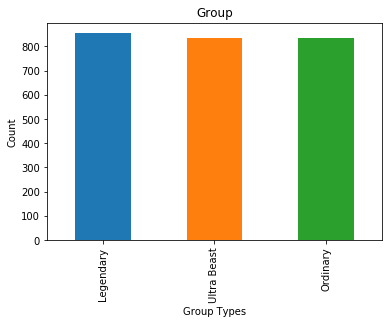

In [75]:
# Plot Group occurences to see the distributions
groupFig, groupAxes = plt.subplots(nrows=1, ncols=1)
groupCounts = r["Group"].value_counts()
groupAxe = groupCounts.plot(title="Group", kind="bar")
groupAxe.set(xlabel="Group Types", ylabel="Count")

In [ ]:
# Box plot Total & Group
data.boxplot("Total", "Group")

<p> According to the boxplot above, we can see that despite having a small quanity in size, Legendary Pokemon has the highest Total stats compared to the other 2 groups.</p>

## PCA

In [ ]:
reducedData = data.drop(DropColumns, axis=1)
# dummies = pd.get_dummies(data[["Type 1", "Type 2", "Ability 1", "Ability 2", "Ability 3", "EggGroup 1", "EggGroup 2"]])
# dataWithDummies = pd.concat([dummies, reducedData], axis=1, join_axes=[reducedData.index])

# x = dataWithDummies.loc[:, dataWithDummies.columns != "Group"]
# y = dataWithDummies.loc[:, "Group"]

# Scale the x data
#x = StandardScaler().fit_transform(x)

In [ ]:
pca = PCA(0.95)
principalComponents = pca.fit_transform(x)
width, height = principalComponents.shape
principalDf = pd.DataFrame(data=principalComponents, columns=["pca %d" % i for i in range(1, height + 1)])
pcaData = pd.concat([principalDf, dataWithDummies[["Group"]]], axis=1)

xTrain = pcaData.sample(frac=0.5)

In [ ]:
# # Plot Type 1 and Type 2 occurences to see the distributions
# typeFig, typeAxes = plt.subplots(nrows=3, ncols=1)
# typeFig.subplots_adjust(top=3)

# type1Counts = data["Type 1"].value_counts()
# type2Counts = data["Type 2"].value_counts().drop("None")
# typesCounts = type1Counts.add(type2Counts, fill_value=0)

# type1Counts.plot(title="Type 1 Occurrences", kind="bar", ax=typeAxes[0], color=getColorList(type1Counts))
# type2Counts.plot(title="Type 2 Occurrences", kind="bar", ax=typeAxes[1], color=getColorList(type2Counts))
# typesCounts.plot(title="Type 1 + 2 Occurrences", kind="bar", ax=typeAxes[2], color=getColorList(typesCounts))

# fh = FeatureHasher(n_features=2, input_type="string")
# hashedFeature1 = fh.fit_transform(data["Type 1"])
# hashedFeature2 = fh.fit_transform(data["Type 2"])

# x = pd.concat([data[["Name", "Type 1", "Type 2", "Category"]], pd.DataFrame(hashedFeature1.toarray())], axis=1)
# x = pd.concat([x, pd.DataFrame(hashedFeature2.toarray())], axis=1)

## Training & Test Data

In [110]:
target = "Group"
labels = data[target].unique()
r = ut.injectMinoritySample(["Ultra Beast", "Legendary"], "Group", data)
reducedData = r.drop(DropColumns, axis=1)
training, test = ut.splitData(target, reducedData, 0.60)
k = 10
kTrainings, kTests = ut.kFoldCrossValidation(k, training, True, target)

## Decision Tree

In [126]:
dtree = dt.DecisionTree(target, 4)
dtree.train(training)
dtPred = dtree.classify(test.drop([target], axis=1))

Function "train" took 30.70 seconds to complete


In [127]:
dtMatrix = ut.buildConfusionMatrix(dtPred, test[target], reducedData[target].unique())
dtPrecisions, dtRecalls = ut.getPrecisionsAndRecalls(dtMatrix, reducedData[target].unique())
dtFScores = ut.computeFScores(dtPrecisions, dtRecalls)
"Error {0:.2f}%".format(ut.computeError(dtPred, test["Group"]) * 100)

'Error 0.40%'

In [131]:
errors = []
for kTraining, kTest in zip(kTrainings, kTests):
    dtree.train(kTraining)
    kPred = dtree.classify(kTest.drop([target], axis=1))

    error = ut.computeError(kPred, kTest["Group"])    
    errors.append(error)

Function "train" took 30.07 seconds to complete
Function "train" took 27.36 seconds to complete
Function "train" took 26.79 seconds to complete
Function "train" took 27.03 seconds to complete
Function "train" took 25.98 seconds to complete
Function "train" took 28.96 seconds to complete
Function "train" took 24.79 seconds to complete
Function "train" took 25.04 seconds to complete
Function "train" took 25.17 seconds to complete
Function "train" took 26.22 seconds to complete


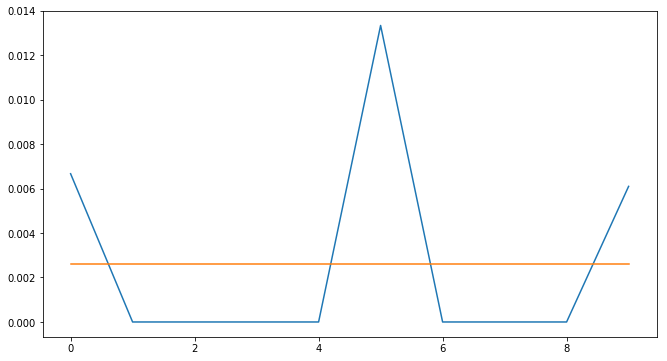

In [144]:
plt.plot([i for i in range(k)], errors)
plt.plot([i for i in range(k)], [sum(errors) / k for i in range(k)])

In [ ]:
treeDepths = [i for i in range(10)]
errors = []
for depth in treeDepths:
    learner = dt.DecisionTree(target, depth)
    learner.train(training)
    pred = learner.classify(test.drop([target], axis=1))
    err = ut.computeError(pred, test["Group"])
    errors.append(err)
    
trainErrors = []
for depth in treeDepths:
    learner = dt.DecisionTree(target, depth)
    learner.train(training)
    pred = learner.classify(training.drop([target], axis=1))
    err = ut.computeError(pred, training["Group"])
    trainErrors.append(err)

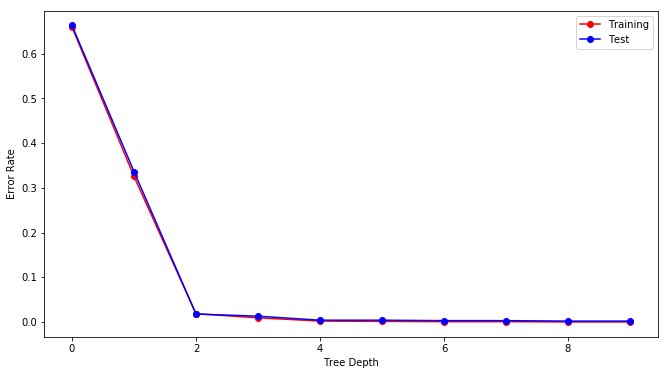

In [88]:
plt.plot(treeDepths, trainErrors, 'ro-', label="Training")
plt.plot(treeDepths, errors, 'bo-', label="Test")
plt.xlabel("Tree Depth")
plt.ylabel("Error Rate")
plt.legend(loc="best")

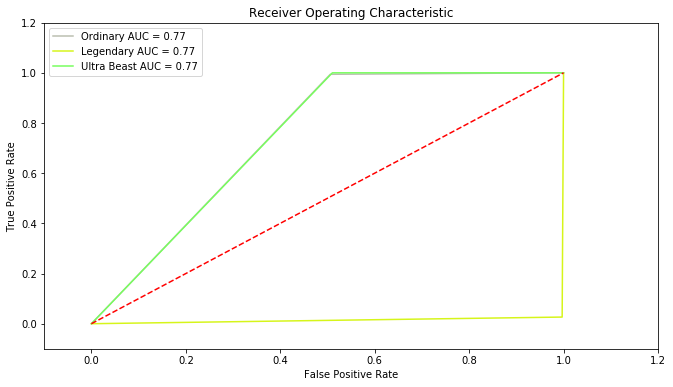

In [128]:
for label in labels:
    c = getRandomColor()
    fpr, tpr, thresholds = roc_curve(y_true=test[target], y_score=[v[1] for v in dtPred.values], pos_label=label)
    rocAuc = auc(fpr, tpr)
    plt.plot(fpr, tpr, c, label='{0} AUC = {1:.2f}'.format(label, roc_auc))
    
plt.title('Receiver Operating Characteristic')
plt.legend(loc='best')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Naive Bayes

In [119]:
nBayes = nb.NaiveBayes(target)
nBayes.train(training, reducedData[target].unique())
nbPred = nBayes.classify(test.drop([target], axis=1))

Function "train" took 8.17 seconds to complete
Function "classify" took 49.32 seconds to complete


In [120]:
nbMatrix = ut.buildConfusionMatrix(nbPred, test[target], reducedData[target].unique())
nbPrecisions, nbRecalls = ut.getPrecisionsAndRecalls(nbMatrix, reducedData[target].unique())
nbFScores = ut.computeFScores(nbPrecisions, nbRecalls)
nbSens, nbSpec = ut.getSensitivityAndSpecifiicy(nbMatrix, reducedData[target].unique())
"Error: {0:.2f}%".format(ut.computeError(nbPred, test["Group"]) * 100)

'Error: 16.73%'

In [138]:
nberrors = []
for kTraining, kTest in zip(kTrainings, kTests):
    nBayes.train(kTraining, labels)
    kPred = nBayes.classify(kTest.drop([target], axis=1))

    error = ut.computeError(kPred, kTest["Group"])    
    nberrors.append(error)

Function "train" took 7.50 seconds to complete
Function "classify" took 6.03 seconds to complete
Function "train" took 7.68 seconds to complete
Function "classify" took 5.78 seconds to complete
Function "train" took 7.10 seconds to complete
Function "classify" took 6.26 seconds to complete
Function "train" took 7.22 seconds to complete
Function "classify" took 5.67 seconds to complete
Function "train" took 7.78 seconds to complete
Function "classify" took 6.13 seconds to complete
Function "train" took 6.73 seconds to complete
Function "classify" took 5.94 seconds to complete
Function "train" took 7.76 seconds to complete
Function "classify" took 6.15 seconds to complete
Function "train" took 7.90 seconds to complete
Function "classify" took 5.87 seconds to complete
Function "train" took 7.56 seconds to complete
Function "classify" took 8.33 seconds to complete
Function "train" took 7.78 seconds to complete
Function "classify" took 7.27 seconds to complete


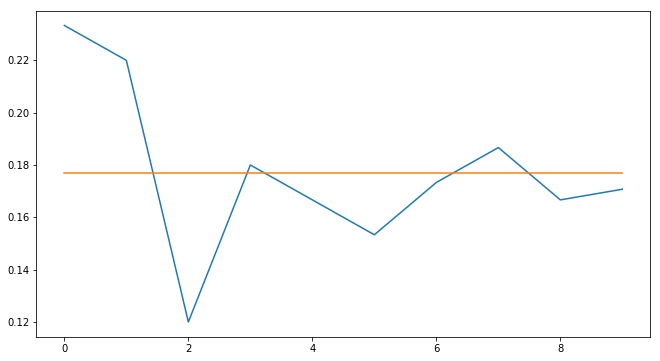

In [143]:
plt.plot([i for i in range(k)], nberrors)
plt.plot([i for i in range(k)], [sum(nberrors) / k for i in range(k)])

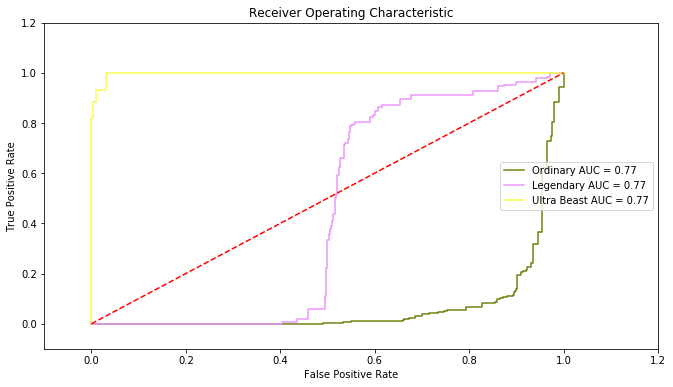

In [124]:
for label in labels:
    c = getRandomColor()
    fpr, tpr, thresholds = roc_curve(y_true=test[target], y_score=[v[1] for v in nbPred.values], pos_label=label)
    rocAuc = auc(fpr, tpr)
    plt.plot(fpr, tpr, c, label='{0} AUC = {1:.2f}'.format(label, roc_auc))
    
plt.title('Receiver Operating Characteristic')
plt.legend(loc='best')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
nberrors = []
nbmatrices = []
nbprecisions = []
nbrecalls = []
nbfScores = []

for kTraining, kTest in zip(kTrainings, kTests):
    nBayes.train(kTraining,  reducedData[target].unique())
    kPred = nBayes.classify(kTest.drop([target], axis=1))
    
    kMatrix = ut.buildConfusionMatrix(kPred, kTest[target], reducedData[target].unique())
    kPrecisions, kRecalls = ut.getPrecisionsAndRecalls(kMatrix, reducedData[target].unique())
    kFScores = ut.computeFScores(kPrecisions, kRecalls)
    error = ut.computeError(kPred, kTest["Group"])
    
    nberrors.append(error)
    nbmatrices.append(kMatrix)
    nbprecisions.append(kPrecisions)
    nbrecalls.append(kRecalls)
    nbfScores.append(kFScores)

### Evaluation Metric

In [ ]:
k = 10
nBayes = nb.NaiveBayes(target)
sens = []
specs = []

for i in range(k):
    training, test = ut.splitData(target, reducedData, 0.60)    
    nBayes.train(training, reducedData[target].unique())
    nbPred = nBayes.classify(test.drop([target], axis=1))
    
    nbMatrix = ut.buildConfusionMatrix(nbPred, test[target], reducedData[target].unique())
    nbSens, nbSpec = ut.getSensitivityAndSpecifiicy(nbMatrix, reducedData[target].unique())
    
    sens.append(nbSens)
    specs.append(nbSpec)

In [ ]:
ordinarySens = [sens[i]["Ordinary"] for i in range(k)]
ordinarySpecs = sorted([specs[i]["Ordinary"] for i in range(k)])

In [ ]:
t = "Legendary"
s = sorted([(sens[i][t], specs[i][t]) for i in range(k)], key=lambda x: x[1])

In [ ]:
plt.plot(list(map(lambda x: 1- x, [i[1] for i in s])), [i[0] for i in s], 'bo-', label="Ordinary ROC Curve")
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivy")
plt.legend(loc="best")

In [47]:
from sklearn.metrics import roc_curve, auc

In [ ]:
training, test = ut.splitData(target, reducedData, 0.60)    
nBayes.train(training, reducedData[target].unique())
nbPred = nBayes.classify(test.drop([target], axis=1))

nbMatrix = ut.buildConfusionMatrix(nbPred, test[target], reducedData[target].unique())
nbSens, nbSpec = ut.getSensitivityAndSpecifiicy(nbMatrix, reducedData[target].unique())

In [ ]:
p = list(map(lambda x: 1 if x == "Ordinary" else 0, nbPred.values))
a = list(map(lambda x: 1 if x == "Ordinary" else 0, test["Group"]))

false_positive_rate, true_positive_rate, thresholds = roc_curve(a, p)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

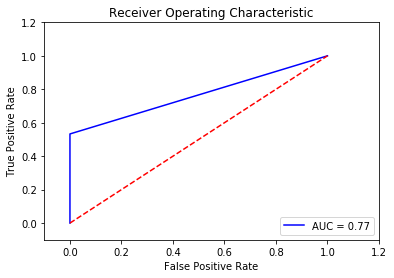

In [51]:
p = [] 

for v in nbPred.sort_index().values:
    if v[0] != "Legendary":
        p.append(0)
    else:
        p.append(v[1])

t = [v for v in test["Group"].sort_index().values]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true=t, y_score=p, pos_label="Legendary")
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# ut.computeError(dtPred, test["Group"])
roc_curve(y_true=t, y_score=p, pos_label="Ordinary")
# dtPred.values
# p

### Playground

In [73]:
r = ut.injectMinoritySample(["Ultra Beast", "Legendary"], "Group", data)

Ultra Beast 836
Legendary 855


In [74]:
r[target].value_counts()

Legendary      855
Ultra Beast    836
Ordinary       833
Name: Group, dtype: int64

### Plot Error Rate

In [ ]:
def plotPrecisionRecall(precisions, recalls):
    assert len(precisions) == len(recalls), "Length of precisions and recalls must match"
    assert precisions.keys() == recalls.keys(), "Keys in precisions and recalls must match"
    
    for label in precisions.keys():
        pValue = precisions[label]
        rValue = recalls[label]
        

In [ ]:
ratios = [0.2, 0.4, 0.6, 0.8]
dt = DecisionTree("Group")
x = []
y = []

for ratio in ratios:
    print("************ Split ratio: ", ratio)
    training, test = splitData(data, ratio)
    node = dt.train(training)
    predictions = dt.classify(test, node)
    error = computeError(predictions, test[dt.targetFeature])
    
    x.append(len(training))
    y.append(error)

In [ ]:
plt.plot(x, y, 'bo-', label="With categorical and continuous features")
plt.xlabel("Trainging Set size")
plt.ylabel("Error Rate")
plt.legend(loc="best")

In [ ]:
# Get data profile
profile = pdp.ProfileReport(dataWithDummies)
profile.to_file("Profile.html")
profile = None
gc.collect()